In this notebook we'll experiment how to get the optical image (i.e., after applying PSF) starting from the spectral image obtained from `spectral_emission_flux()`

In [1]:
from microsim import schema as ms
import numpy as np
import math

In [2]:
# Define a simple Filter through a function that allows us to set min and max values for the spectrum
def create_custom_channel(
    min_wave: int = 300, 
    max_wave: int = 800,
) -> ms.optical_config.OpticalConfig:

    custom_spectrum = ms.Spectrum(
        wavelength=np.arange(min_wave, max_wave, 1),
        intensity=np.ones(max_wave - min_wave),
    )

    custom_filter = ms.optical_config.SpectrumFilter(transmission=custom_spectrum) # placement=ALL by default

    custom_channel = ms.optical_config.OpticalConfig(
        name="FEDERICO",
        filters=[custom_filter],
    )
    
    return custom_channel

In [3]:
my_ch = create_custom_channel()

print(my_ch.filters[0].spectrum)
print(my_ch.filters[0].spectrum.wavelength.shape, type(my_ch.filters[0].spectrum.wavelength))
print(my_ch.filters[0].spectrum.intensity.shape, type(my_ch.filters[0].spectrum.intensity), max(my_ch.filters[0].spectrum.intensity))

wavelength=ndarray<shape=(500,) dtype=int64 units=nanometer> intensity=ndarray<shape=(500,) dtype=float64> scalar=1.0
(500,) <class 'pint.registry.Quantity'>
(500,) <class 'numpy.ndarray'> 1.0


Instantiate `Simulation` object

In [4]:
from microsim.schema.optical_config import lib

sim = ms.Simulation(
    truth_space=ms.ShapeScaleSpace(shape=(52, 512, 512), scale=(0.064, 0.064, 0.064)),
    output_space={"downscale": 2},
    sample=ms.Sample(
        labels=[
            ms.FluorophoreDistribution(
                distribution=ms.CosemLabel(dataset="jrc_hela-3", label="ne_pred"),
                fluorophore="mTurquoise",
            ),
            ms.FluorophoreDistribution(
                distribution=ms.CosemLabel(dataset="jrc_hela-3", label="er-mem_pred"),
                fluorophore="EYFP",
            ),
            ms.FluorophoreDistribution(
                distribution=ms.CosemLabel(dataset="jrc_hela-3", label="mito-mem_pred"),
                fluorophore="mScarlet",
            ),
        ]
    ),
    channels= [create_custom_channel(min_wave=300, max_wave=800)],
    modality=ms.Confocal(pinhole_au=2),
    detector=ms.CameraCCD(qe=0.82, read_noise=6),
    output_path="h2-cf.tif",
    settings=ms.Settings(max_psf_radius_aus=2),
    emission_bins=32
)

### Simulate `ground_truth` array

In [5]:
gt = sim.ground_truth()
print(gt.shape, gt.coords) # (F, Z, Y, X)

I0000 00:00:1719412922.080647   35587 s3_resource.cc:108] Using default AdmissionQueue with limit 32
W0000 00:00:1719412922.918370   35771 curl_transport.cc:452] Error [28]=Timeout was reached in curl operation
Failed to connect to 169.254.169.254 port 80 after 200 ms: Timeout was reached
W0000 00:00:1719412929.597582   35771 curl_transport.cc:452] Error [28]=Timeout was reached in curl operation
Failed to connect to 169.254.169.254 port 80 after 202 ms: Timeout was reached
W0000 00:00:1719412935.485218   35771 curl_transport.cc:452] Error [28]=Timeout was reached in curl operation
Failed to connect to 169.254.169.254 port 80 after 200 ms: Timeout was reached


(3, 52, 512, 512) Coordinates:
  * z        (z) float64 416B 0.0 0.064 0.128 0.192 ... 3.072 3.136 3.2 3.264
  * y        (y) float64 4kB 0.0 0.064 0.128 0.192 ... 32.51 32.58 32.64 32.7
  * x        (x) float64 4kB 0.0 0.064 0.128 0.192 ... 32.51 32.58 32.64 32.7
  * f        (f) object 24B distribution=CosemLabel(type='cosem', dataset='jr...


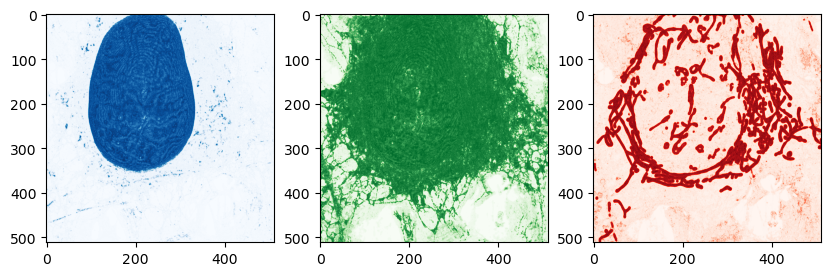

In [6]:
# Print the fluorophore distribution
import matplotlib.pyplot as plt

# Make MIP over z-axis
gt_mip = gt.max(dim='z')

cmaps = ["Blues", "Greens", "Reds", "Grays"]
_, ax = plt.subplots(1, gt_mip.shape[0], figsize=(10, 5))
for i in range(gt_mip.shape[0]):
    ax[i].imshow(gt_mip[i, ...], cmap=cmaps[i])

### Get the spectral emission flux

In [7]:
em_img, em_spectra, em_binned_spectra = sim.spectral_emission_flux(gt, channel_idx=0)

/localscratch/miniforge3/envs/microsim_env/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:239: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/localscratch/miniforge3/envs/microsim_env/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:239: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/localscratch/miniforge3/envs/microsim_env/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:239: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


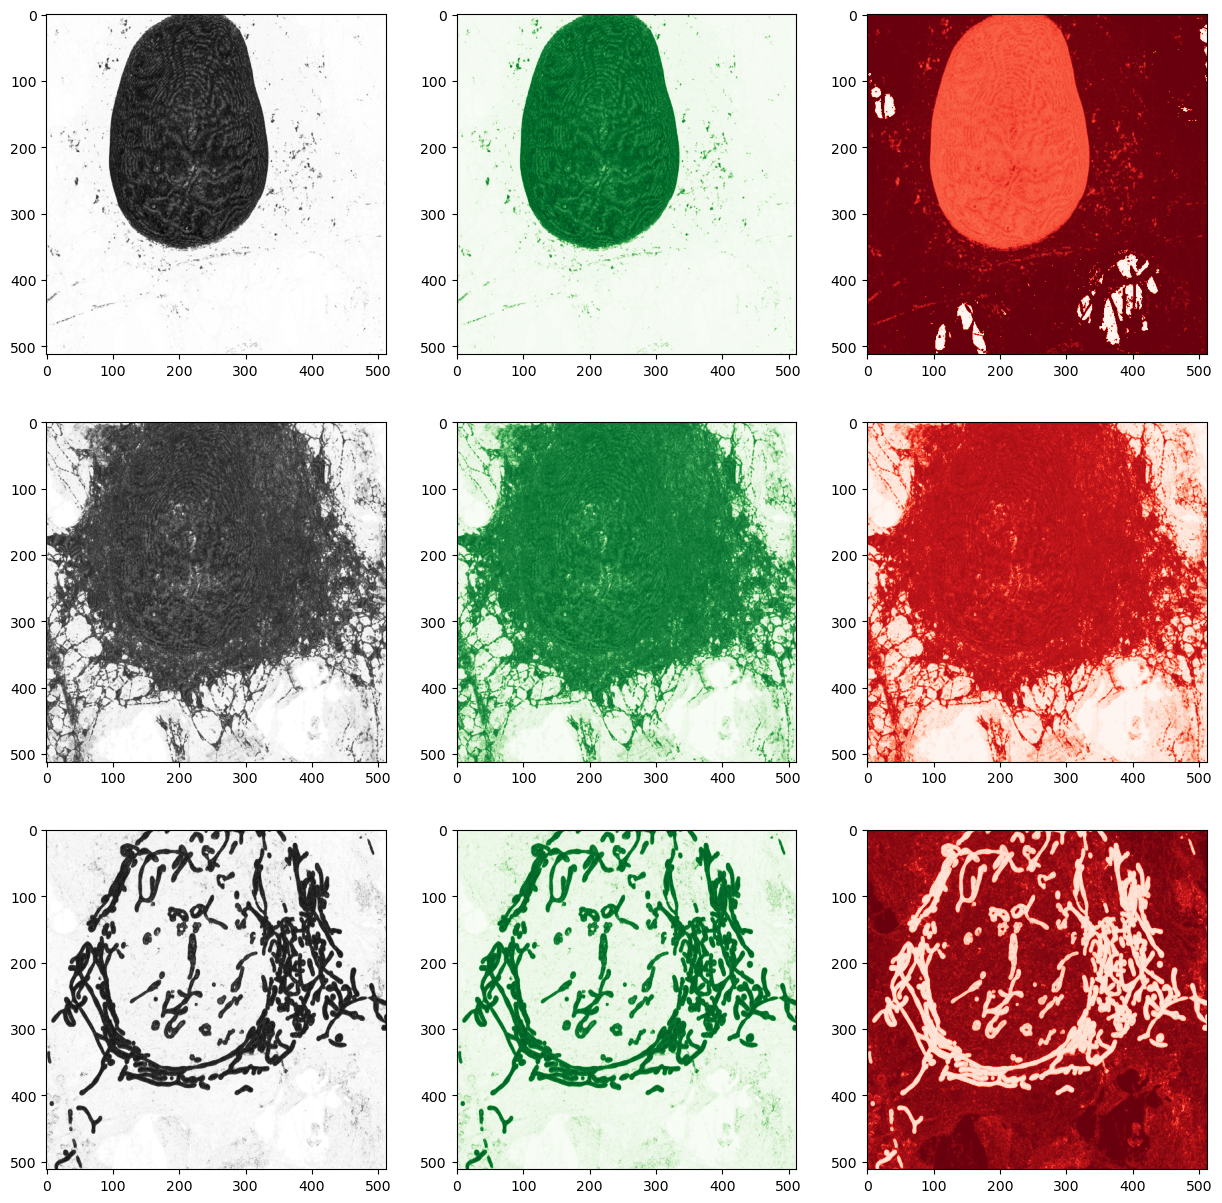

In [8]:
# Print the emission image
from microsim.schema.dimensions import Axis

def normalize_global(data):
    min_val = data.min().item()
    max_val = data.max().item()
    normalized_data = ((data - min_val) / (max_val - min_val) * 65535).astype(np.uint16)
    return normalized_data

fluor1_em_img = em_img[:, :, 0, ...].squeeze()
fluor2_em_img = em_img[:, :, 1, ...].squeeze()
fluor3_em_img = em_img[:, :, 2, ...].squeeze()

fluor1_em_mip = fluor1_em_img.max(dim=Axis.Z)
fluor2_em_mip = fluor2_em_img.max(dim=Axis.Z)
fluor3_em_mip = fluor3_em_img.max(dim=Axis.Z)

norm_fluor1_em_mip = normalize_global(fluor1_em_mip)
norm_fluor2_em_mip = normalize_global(fluor2_em_mip)
norm_fluor3_em_mip = normalize_global(fluor3_em_mip)

_, ax = plt.subplots(3, 3, figsize=(15, 15))
ax[0,0].imshow(norm_fluor1_em_mip[1, ...], cmap="Grays")
ax[0,1].imshow(norm_fluor1_em_mip[5, ...], cmap="Greens")
ax[0,2].imshow(abs(norm_fluor1_em_mip[1, ...] - norm_fluor1_em_mip[5, ...]), cmap="Reds")
ax[1,0].imshow(norm_fluor2_em_mip[6, ...], cmap="Grays")
ax[1,1].imshow(norm_fluor2_em_mip[13, ...], cmap="Greens")
ax[1,2].imshow(abs(norm_fluor2_em_mip[6, ...] - norm_fluor2_em_mip[13, ...]), cmap="Reds")
ax[2,0].imshow(norm_fluor3_em_mip[10, ...], cmap="Grays")
ax[2,1].imshow(norm_fluor3_em_mip[14, ...], cmap="Greens")
ax[2,2].imshow(abs(norm_fluor3_em_mip[10, ...] - norm_fluor3_em_mip[14, ...]), cmap="Reds")

### Get the optical image (current approach)

In [19]:
optical_img = sim.optical_image(em_img, channel_idx=0)

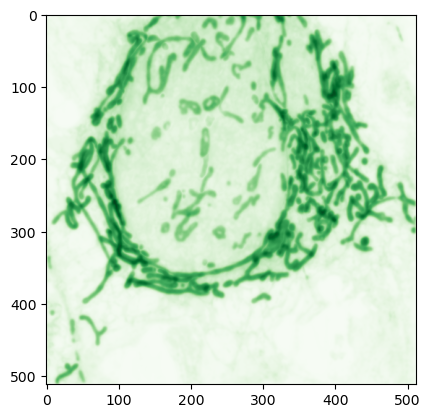

In [12]:
# Make MIP over z-axis
optical_mip = optical_img.squeeze().max(dim='z')

plt.imshow(optical_mip, cmap="Greens")

Why do we get such output? The answer is in these numbers:
```
f"{fp1.mean():.2e}"     f"{fp1.max():.2e}"
'2.02e+08'              '3.40e+10'
f"{fp2.mean():.2e}"     f"{fp2.max():.2e}"
'7.29e+08'              '5.05e+10'
f"{fp3.mean():.2e}"     f"{fp3.max():.2e}"
'8.34e+08'              '7.79e+10'
```

That is FP3 intensity is much greater than the other 2 on average. Therefore, when we sum the FP's together in the `optical_image()` method, the obvious result is that the signal from the 3rd FP overwhelms the others. 

We can have a better idea of this issue by plotting the histogram of the intensity for the different FPs:

(0.0, 50000000.0)

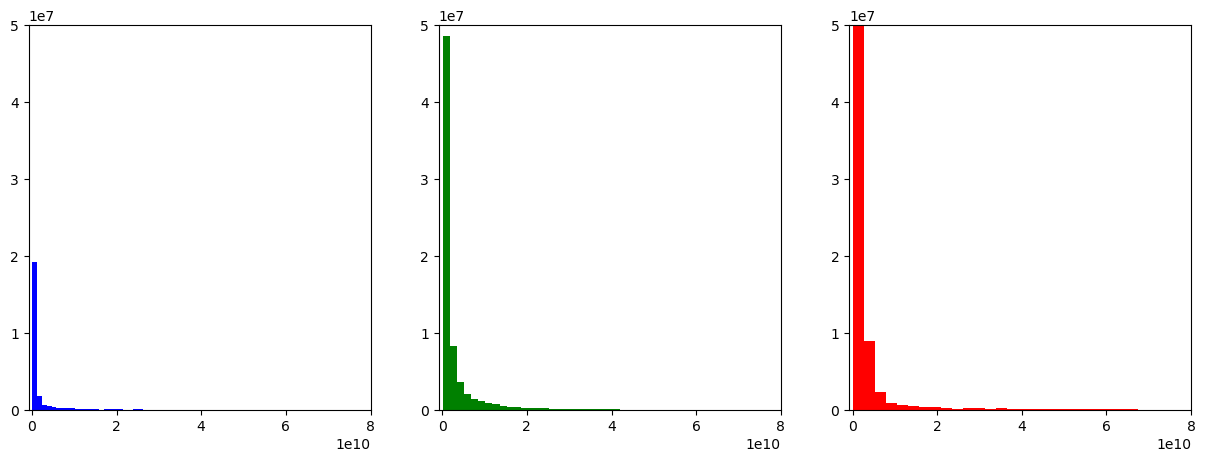

In [31]:
# Plot histogram intensities
_, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(em_img[:, 0, 0, ...].values[em_img[:, 0, 0, ...] > 1e8].flatten(), bins=30, color="blue")
ax[1].hist(em_img[:, 0, 1, ...].values[em_img[:, 0, 1, ...] > 1e8].flatten(), bins=30, color="green")
ax[2].hist(em_img[:, 0, 2, ...].values[em_img[:, 0, 2, ...] > 1e8].flatten(), bins=30, color="red")
# Put same limits for all histograms
ax[0].set_xlim([-.8e9, 8e10])
ax[1].set_xlim([-.8e9, 8e10])
ax[2].set_xlim([-.8e9, 8e10])
ax[0].set_ylim([0, .5e8])
ax[1].set_ylim([0, .5e8])
ax[2].set_ylim([0, .5e8])

Where does this additional intensity come from?

HP1: number of flurophores

In [64]:
gt_fp1 = gt[0, ...].values.flatten()
gt_fp2 = gt[1, ...].values.flatten()
gt_fp3 = gt[2, ...].values.flatten()

In [67]:
print(np.quantile(a=gt_fp1[gt_fp1 > 0], q=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
print(np.quantile(a=gt_fp2[gt_fp2 > 0], q=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
print(np.quantile(a=gt_fp3[gt_fp3 > 0], q=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

print(gt_fp1[gt_fp1 > 0].mean())
print(gt_fp2[gt_fp2 > 0].mean())
print(gt_fp3[gt_fp3 > 0].mean())

[  1.   1.   2.   6.  62. 117. 146.]
[  3.   5.  11.  35.  86. 100. 111.]
[  1.   1.   1.   5.  11.  43. 118.]
15.940155
26.249666
8.014912


That is not true, actually the last fluorophore seems to have the least FP/pixel...

Ask Talley/Ashesh what determines the intensity of a signal (irradiance, ...)

### Get the optical image (new approach)

We saw that in absence of channel information (removed from the game for now), by using the current `optical_image()` method we reduce the *emission_image* to a `(C, Z, Y, X)` array. By doing this we automatically lose all the spectral information, since the signal is not anymore separated at different wavelengths.

A simple approach to overcome this issue for the moment is to apply the *PSF convolution* separately for each flurophore `F` and each spectral band `W`. To do this we need to create a custom `spectral_optical_image()` that defines an alternative `spectral_render()` method of the current modality in similar spirit to what we have done with the `emission_flux()`.